### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук
#### Кафедра математического моделирования и искусственного интеллекта


## ОТЧЕТ ПО ТЕМЕ № 2

### Дисциплина: Глубокое обучение



##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИмд-01-25

In [1]:
IMAGE_SIZE = 32
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 64
EPOCHS = 20
BETA = 500

In [2]:
import tensorflow as tf
tf.config.list_logical_devices("GPU")

W0000 00:00:1758932769.698381 1041011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758932769.698399 1041011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758932769.698401 1041011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758932769.698402 1041011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-09-27 03:26:09.701514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other o

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
import keras
from keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils,
)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [5]:
# 1032259322 -> 2395

# leave only those digits that are in the set
feats = [2, 3, 5, 9]
train_idx = [i[0] for i in enumerate(y_train) if i[1] in feats]
test_idx = [i[0] for i in enumerate(y_test) if i[1] in feats]

x_train_filter = []
y_train_filter = []
for i in train_idx:
    x_train_filter.append(x_train[i])
    y_train_filter.append(y_train[i])
    
x_test_filter = []
y_test_filter = []
for i in test_idx:
    x_test_filter.append(x_test[i])
    y_test_filter.append(y_test[i])

x_train = x_train_filter
y_train = y_train_filter
x_test = x_test_filter
y_test = y_test_filter

In [6]:
import numpy as np
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

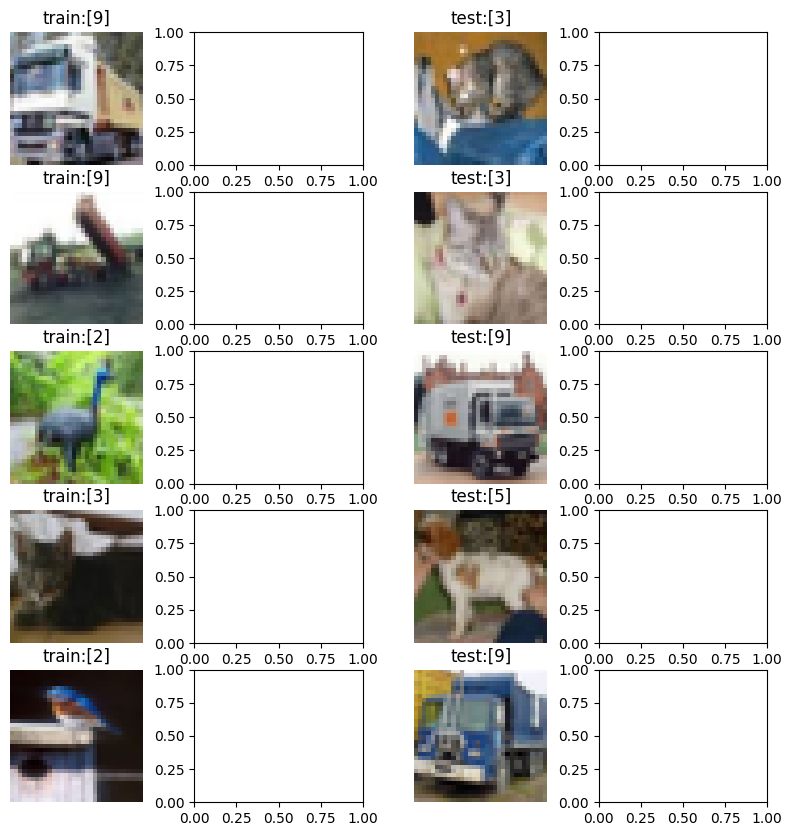

In [7]:
import matplotlib.pyplot as plt

# train images on left, test images on right
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
for i in range(5):
    axes[i, 0].axis("off")
    axes[i, 2].axis("off")
    axes[i, 0].set_title('train:' + str(y_train[i]))
    axes[i, 2].set_title('test:' + str(y_test[i]))
    axes[i, 0].imshow(x_train[i])
    axes[i, 2].imshow(x_test[i])

In [8]:
class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape

img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(img_input)
x = Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:]

x = Flatten()(x)
z_mean = Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(img_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │    131,136 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │    131,136 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,520 (1.36 MB)

 Trainable params: 355,520 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import numpy as np

decoder_input = Input(shape=(EMBEDDING_DIM,))
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
)(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,827 (1.43 MB)

 Trainable params: 373,827 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    # Эта функция формирует выходные данные VAE для конкретного входного изоб
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
        
    # Эта функция описывает один шаг обучения VAE, включая расчет функции пот
    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                    )
            )
            # Общие потери представляют собой сумму потерь реконструкции и
            # потерь KL-дивергенции
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam()
vae.compile(optimizer=optimizer)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 64), (None,    │       355,520 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       373,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729,347 (2.78 MB)

 Trainable params: 729,347 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/20


I0000 00:00:1758932774.594364 1041289 service.cc:152] XLA service 0x7f9b480030a0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758932774.594379 1041289 service.cc:160]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2025-09-27 03:26:14.621491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/313 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - kl_loss: 0.0584 - reconstruction_loss: 346.4018 - total_loss: 346.4601

I0000 00:00:1758932778.935288 1041289 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - kl_loss: 4.7532 - reconstruction_loss: 326.6885 - total_loss: 331.4418 - val_kl_loss: 7.6110 - val_loss: 321.5367 - val_reconstruction_loss: 313.9258
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - kl_loss: 8.8204 - reconstruction_loss: 309.2761 - total_loss: 318.0966 - val_kl_loss: 9.2256 - val_loss: 316.6317 - val_reconstruction_loss: 307.4061
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - kl_loss: 9.2635 - reconstruction_loss: 306.3550 - total_loss: 315.6184 - val_kl_loss: 9.4877 - val_loss: 315.5428 - val_reconstruction_loss: 306.0550
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - kl_loss: 9.4875 - reconstruction_loss: 305.4202 - total_loss: 314.9080 - val_kl_loss: 9.3999 - val_loss: 315.6064 - val_reconstruction_loss: 306.2065
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - kl_loss: 9.6492 - reconstruction_loss: 304.7512 - total_loss: 314.4003 - val_kl_loss: 9.7369 - val_loss: 314.5995 - val_reconstruction_

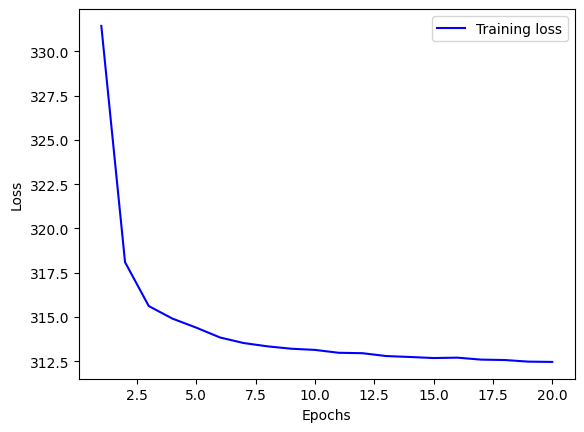

In [14]:
loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


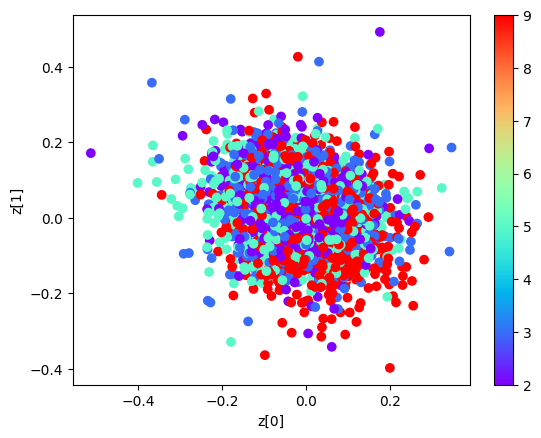

In [15]:
z_mean, z_log_var, z = encoder.predict(x_test)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='rainbow')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


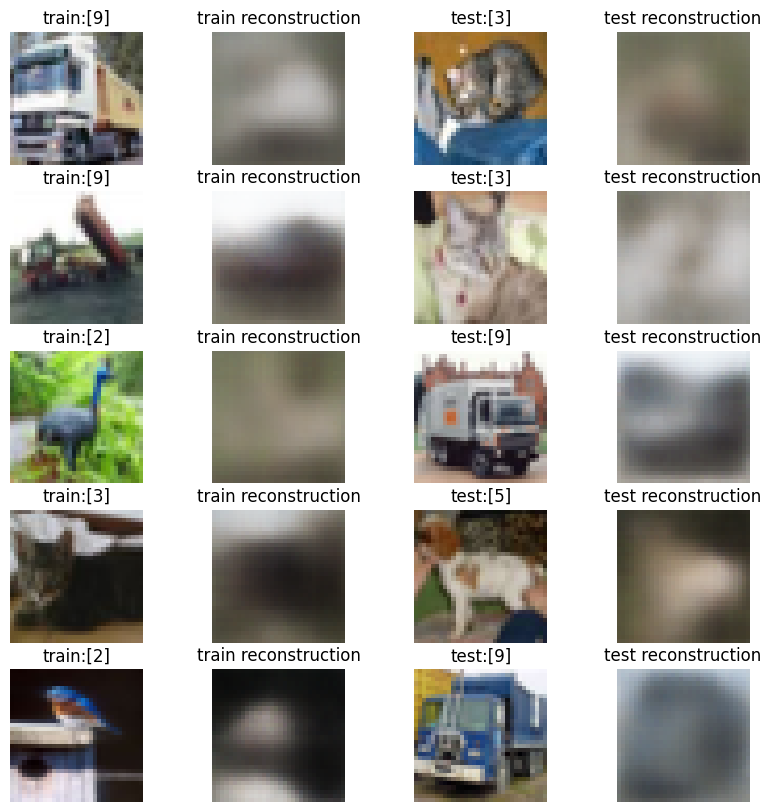

In [16]:
_, _, predictions_train = vae.predict(x_train[:5])
_, _, predictions_test = vae.predict(x_test[:5])
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
for i in range(5):
    axes[i, 0].axis("off")
    axes[i, 2].axis("off")
    axes[i, 0].set_title('train:' + str(y_train[i]))
    axes[i, 2].set_title('test:' + str(y_test[i]))
    axes[i, 0].imshow(x_train[i])
    axes[i, 2].imshow(x_test[i])
    axes[i, 1].axis("off")
    axes[i, 3].axis("off")
    axes[i, 1].set_title('train reconstruction')
    axes[i, 3].set_title('test reconstruction')
    axes[i, 1].imshow(predictions_train[i])
    axes[i, 3].imshow(predictions_test[i])

In [17]:
idx1 = 1 # cat
idx2 = 5 # dog

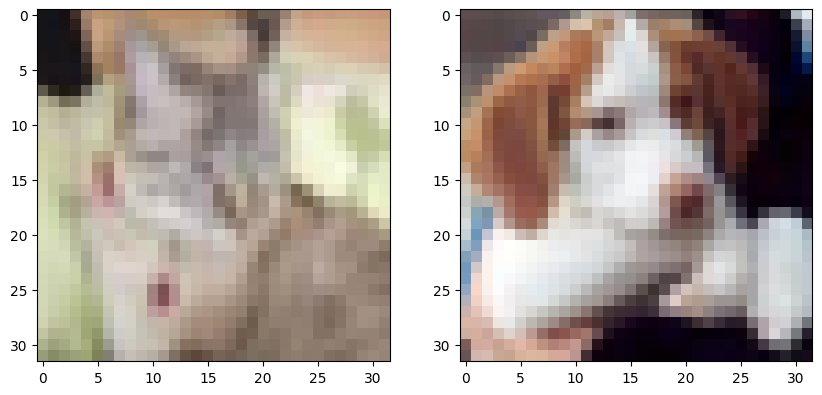

In [18]:
img1 = x_test[idx1]
img2 = x_test[idx2]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img1)
axes[1].imshow(img2)

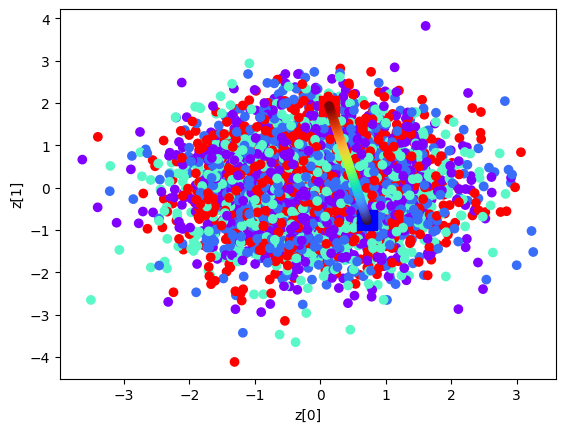

In [19]:
latent1 = z[idx1]
latent2 = z[idx2]

plt.scatter(z[:, 0], z[:, 1], c=y_test, cmap='rainbow')

plt.scatter(latent1[0], latent1[1], c='b', marker='s', s=200)
plt.scatter(latent2[0], latent2[1], c='r', marker='s', s=200)

# show the "path" from cat to dog
n = 50
linear_space = np.linspace(latent1, latent2, n)
plt.scatter(linear_space[:, 0], linear_space[:, 1], c=np.linspace(0, 1, n), cmap='turbo')

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


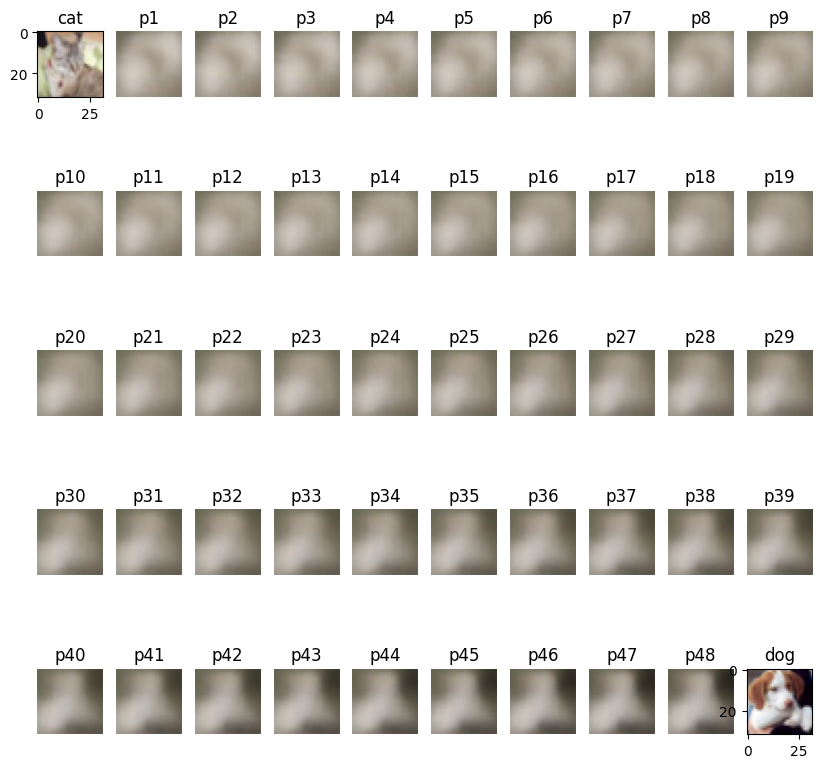

In [20]:
fig, axes = plt.subplots(5, 10, figsize=(10, 10))
axes[0][0].set_title('cat')
axes[0][0].imshow(img1)

axes[4][9].set_title('dog')
axes[4][9].imshow(img2)

linear_predictions = decoder.predict(linear_space)

for i in range(5):
    for j in range(10):
        if (i,j) == (0,0) or (i,j) == (4,9):
            continue
        axes[i][j].imshow(linear_predictions[i * 10 + j])
        axes[i][j].axis('off')
        axes[i][j].set_title('p' + str(i * 10 + j))